SageMaker End to End Training Pipeline

In [ ]:
## references:
# https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html
# https://docs.aws.amazon.com/sagemaker/latest/dg/define-pipeline.html


In [ ]:
!pip install sagemaker
!pip install tensorflow
!pip uninstall opencv-python --yes
!pip install opencv-python-headless


In [98]:
## import libraries:

import sagemaker
from sagemaker import get_execution_role
from sagemaker.workflow.parameters import ParameterInteger, ParameterString

from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.workflow.steps import ProcessingStep, TrainingStep
from sagemaker.workflow.steps import CacheConfig

from sagemaker.model import Model
from sagemaker.model_metrics import MetricsSource, ModelMetrics 
from sagemaker.workflow.step_collections import RegisterModel
from sagemaker.workflow.conditions import ConditionGreaterThanOrEqualTo
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.functions import JsonGet


import boto3

In [99]:
## set up session:
region='us-east-1'

sm_sess = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sm_sess.default_bucket() 
s3_client = boto3.client("s3", region_name=region)

In [100]:
## define variables:

raw_data_uri = 's3://brain-cancer-dataset/raw/'

batch_data_uri = 's3://brain-cancer-dataset/data/test/'

project_name = 'braincancer-classification'
model_name = project_name + '_tf_cnn'

training_type = 'ml.t3.medium'

cache_config = CacheConfig(enable_caching=True,
                           expire_after="15d")


In [101]:
## temporary:
prc_data_uri = 's3://brain-cancer-dataset/processed/'
input_prc_data = ParameterString(
    name="InputData",
    default_value=prc_data_uri,
)

In [102]:
## define Pipeline Parameters:
region = ParameterString(
    name='Region',
    default_value='us-east-1'
)

input_data = ParameterString(
    name="InputData",
    default_value=raw_data_uri,
)

batch_data = ParameterString(
    name="BatchData",
    default_value=batch_data_uri,
)

processing_instance_count = ParameterInteger(
    name='ProcessingInstanceCount',
    default_value=1
)

processing_instance_type = ParameterString(
    name='ProcessingInstanceType',
    default_value='ml.t3.medium'
)

training_instance_count = ParameterInteger(
    name='TrainingInstanceCount',
    default_value=1
)

training_instance_type = ParameterString(
    name='TrainingInstanceType',
    default_value='ml.t3.medium'
)

training_epochs = ParameterString(
    name="TrainingEpochs",
    default_value="10")

model_approval_status = ParameterString(
    name='ModelApprovalStatus',
    default_value='PendingManualApproval'
    #default_value='Approved'
)




In [103]:
from sagemaker.workflow.pipeline_context import PipelineSession
#from sagemaker.workflow.pipeline_context import LocalPipelineSession

pipeline_session = PipelineSession()
#pipeline_session = LocalPipelineSession()

In [104]:
%%writefile preprocess.py


#This script should be run on all images prior to training and prediction to standardize images going through the model.
# preprocess.py takes in raw MRI images of the Brain (extensions jpg, jpeg and png) and processes them for the machine learning model.  
# This processing includes:  
# 1- converting images to gray scale and reducing multi-channel images to a single channel  
# 2- scaling pixel intensity to a 0-1 scale
# 3- cropping black space around the image  
# 4- scaling image size to 200 x 200 pixels  
# 5- standardizing file extensions  



import os
import numpy as np
import subprocess
import sys

## install headless opencv due to issue with sagemaker
subprocess.check_call([sys.executable, "-m", "pip", "install", "opencv-python-headless"])
import cv2

## functions:

def get_imgs(img_path_array):
    """function that loads images into an array given image paths"""
    imgs = []
    for path in img_path_array:
        img = cv2.imread(path)
        imgs.append(img)
    return imgs


def zero_runs(arr):
    """function that detects consecutive zeros"""
    # Create an array that is 1 where a is 0, and pad each end with an extra 0.
    iszero = np.concatenate(([0], np.equal(arr, 0).view(np.int8), [0]))
    absdiff = np.abs(np.diff(iszero))
    # Runs start and end where absdiff is 1.
    ranges = np.where(absdiff == 1)[0].reshape(-1, 2)
    return ranges


def crop_img(img, threshold=0.1):
    """function that crops an array based on a threshold"""
    img_len, img_width = img.shape
    x_min, y_min, x_max, y_max = 0, 0, img_width, img_len
    mask = img > threshold
    bounds_x = zero_runs(mask.sum(axis=0))
    bounds_y = zero_runs(mask.sum(axis=1))
    # if there are zero runs, check if they start at 0 and end at image len
    if bounds_x.size != 0:
        if bounds_x[0][0] == 0:
            x_min = bounds_x[0][1]

        if bounds_x[-1][1] == x_max:
            x_max = bounds_x[-1][0]

    if bounds_y.size != 0:
        if bounds_y[0][0] == 0:
            y_min = bounds_y[0][1]

        if bounds_y[-1][1] == y_max:
            y_max = bounds_y[-1][0]

    return img[y_min:y_max, x_min:x_max]


def process_img(img, img_size = (200, 200)):
    """function that processes the images.
    It converts them to gray scale with 1 channel only.
    It scales them to 0-1, crops negative space around them and resizes them"""
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_grey_norm = (img_grey / 255)
    img_grey_cropped = crop_img(img_grey_norm)
    img_grey_std = cv2.resize(img_grey_cropped, img_size)
    return img_grey_std

## process images and save them in new path

def imgs_raw_to_process(imgs_path, output_dir, ext=".jpg"):
    for img_path in imgs_path:
        # load img:
        img = cv2.imread(img_path)
        # process image
        new_img = process_img(img)
        # get new file name and path:
        old_filename = os.path.basename(img_path)
        old_filename_no_ext = "".join(list(os.path.splitext(old_filename))[:-1])
        new_filename = "prc_" + old_filename_no_ext + ext
        new_file_path = os.path.join(output_dir, new_filename)
        cv2.imwrite(new_file_path, new_img)


if __name__ == "__main__":
    print("... ... ... Starting Processing Script... ... ...")
    
    
    base_dir = "/opt/ml/processing/"

    neg_prc_imgs_path = os.path.join(base_dir, "output/processed/no")
    pos_prc_imgs_path = os.path.join(base_dir, "output/processed/yes")

    ## create new folders:
    if not os.path.exists(neg_prc_imgs_path):
        os.makedirs(neg_prc_imgs_path)

    if not os.path.exists(pos_prc_imgs_path):
        os.makedirs(pos_prc_imgs_path)
        
    ## load raw data:
    img_extentions = (".png", ".jpg", ".jpeg")

    ## normal scans
   
    neg_path = os.path.join(base_dir, "input/no/")
    neg_imgs_path = [os.path.join(neg_path, file) for file in os.listdir(neg_path) if file.lower().endswith(img_extentions)]

    ## brain cancer scans
    pos_path = os.path.join(base_dir, "input/yes/")
    pos_imgs_path = [os.path.join(pos_path, file) for file in os.listdir(pos_path) if file.lower().endswith(img_extentions)]
    
    ## process images and save them in new path
    print("... ... ... Processing Images... ... ...")
    
    imgs_raw_to_process(neg_imgs_path, neg_prc_imgs_path)
    imgs_raw_to_process(pos_imgs_path, pos_prc_imgs_path)
    
    print("... ... ... Processing Script Complete... ... ...")



Overwriting preprocess.py


In [105]:
s3_client.upload_file(
    Filename="preprocess.py", Bucket=bucket, Key=f"{project_name}/code/preprocess.py"
)

In [106]:
# Reference: https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html

## define Pre-Processing step

sklearn_framework_version = "0.23-1"

sklearn_processor = SKLearnProcessor(
    framework_version=sklearn_framework_version,
    instance_type=training_type,
    instance_count=processing_instance_count,
    base_job_name=project_name,
    role=role,
    sagemaker_session=pipeline_session
)

inputs = [
    ProcessingInput(source=input_data, destination="/opt/ml/processing/input"),
]

outputs = [
    ProcessingOutput(output_name='processed-data', source='/opt/ml/processing/output/processed')
]

step_process = ProcessingStep(
    name='process-raw-images',
    processor=sklearn_processor,
    inputs=inputs,
    outputs=outputs,
    code='preprocess.py',
    cache_config=cache_config
)




In [107]:
## split data to train, test and validate

In [108]:
%%writefile split.py

import os
import numpy as np
import boto3
from sklearn.model_selection import train_test_split
import subprocess
import sys

## install headless opencv due to issue with sagemaker
subprocess.check_call([sys.executable, "-m", "pip", "install", "opencv-python-headless"])
import cv2

subprocess.check_call([sys.executable, "-m", "pip", "install", "mxnet"])
import mxnet as mx

subprocess.check_call([sys.executable, "-m", "pip", "install", "tqdm"])
from tqdm import tqdm

# method from https://github.com/aws/amazon-sagemaker-examples/blob/main/use-cases/computer_vision/metastases-detection-pipeline.ipynb
def write_to_recordio(X: np.ndarray, y: np.ndarray, prefix: str):
    record = mx.recordio.MXIndexedRecordIO(idx_path=f"{prefix}.idx", uri=f"{prefix}.rec", flag="w")
    for idx, arr in enumerate(tqdm(X)):
        header = mx.recordio.IRHeader(0, y[idx], idx, 0)
        s = mx.recordio.pack_img(
            header,
            arr,
            quality=95,
            img_fmt=".jpg",
        )
        record.write_idx(idx, s)
    record.close()
    

if __name__ == "__main__":
    print("... ... ... Starting Processing Script... ... ...")

    region = 'us-east-1'
    data_bucket = 'brain-cancer-dataset'
    prefix = 'data'
    
    s3_client = boto3.client("s3", region_name=region)
    
    img_extention = (".jpg")

    base_dir = "/opt/ml/processing/"

    neg_prc_imgs_dir = os.path.join(base_dir, "input/processed/no")
    pos_prc_imgs_dir = os.path.join(base_dir, "input/processed/yes")


    ## collect image paths:
    neg_imgs_path = [os.path.join(neg_prc_imgs_dir, file) for file in os.listdir(neg_prc_imgs_dir) if file.lower().endswith(img_extention)]
    pos_imgs_path = [os.path.join(pos_prc_imgs_dir, file) for file in os.listdir(pos_prc_imgs_dir) if file.lower().endswith(img_extention)]
    
    ## load negative data:
    neg_data = []
    for img_path in neg_imgs_path:
        img = cv2.imread(img_path)
        neg_data.append(img)

    neg_labels = [0] * len(neg_data)

    ## load positive data:
    pos_data = []
    for img_path in pos_imgs_path:
        img = cv2.imread(img_path)
        pos_data.append(img)

    pos_labels = [1] * len(pos_data)

    ## merge data:

    X_data = np.array(neg_data + pos_data)
    y_labels = np.array(neg_labels + pos_labels)
    
    print("... ... ... Splitting Images... ... ...")

    ## split data as train and test data:
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_labels, test_size=0.3, shuffle=True, random_state=1)

    ## further split the test data into test and validate:
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.3, random_state=1)

    print(X_train.shape)

    output_dir = os.path.join(base_dir, "output")
    
    write_to_recordio(X_train, y_train, prefix=f"{output_dir}/train/train")
    write_to_recordio(X_val, y_val, prefix=f"{output_dir}/validation/validation")
    write_to_recordio(X_test, y_test, prefix=f"{output_dir}/test/test")
    
    np.savez(f"{output_dir}/train/train", image=X_train, label=y_train)
    np.savez(f"{output_dir}/validation/validation", image=X_val, label=y_val)
    np.savez(f"{output_dir}/test/test", image=X_test, label=y_test)
    
    print(os.listdir(output_dir))
    print(os.listdir(f"{output_dir}/train"))
        
    s3_client.upload_file(f"{output_dir}/train/train.rec", data_bucket, f"{prefix}/train/train.rec")
    s3_client.upload_file(f"{output_dir}/validation/validation.rec", data_bucket, f"{prefix}/validation/validation.rec")
    s3_client.upload_file(f"{output_dir}/test/test.rec", data_bucket, f"{prefix}/test/test.rec")
    s3_client.upload_file(f"{output_dir}/train/train.npz", data_bucket, f"{prefix}/train/train.npz")
    s3_client.upload_file(f"{output_dir}/validation/validation.npz", data_bucket, f"{prefix}/validation/validation.npz")
    s3_client.upload_file(f"{output_dir}/test/test.npz", data_bucket, f"{prefix}/test/test.npz")
    
    print("... ... ... Processing Script Complete... ... ...")
    

Overwriting split.py


In [109]:
s3_client.upload_file(
    Filename="split.py", Bucket=bucket, Key=f"{project_name}/code/split.py"
)

In [110]:
inputs = [
    ProcessingInput(source=step_process.properties.ProcessingOutputConfig.Outputs['processed-data'].S3Output.S3Uri,
                    #source=input_prc_data,
                    destination="/opt/ml/processing/input/processed"),
]

outputs = [
        ProcessingOutput(
                output_name='train',
                source='/opt/ml/processing/output/train'),
        ProcessingOutput(
                output_name='validation',
                source='/opt/ml/processing/output/validation'),
        ProcessingOutput(
                output_name='test',
                source='/opt/ml/processing/output/test')

]

step_split_dataset = ProcessingStep(
    name='split-prc-images',
    processor=sklearn_processor,
    inputs=inputs,
    outputs=outputs,
    code='split.py',
    cache_config=cache_config
)


In [111]:
## Configure Model Estimator

In [112]:
#https://docs.aws.amazon.com/sagemaker/latest/dg/image-classification.html
# supported insances: P2, P3, G4dn, and G5 instances

num_training_samples = 174 ## should not be hard coded

estimator_image = sagemaker.image_uris.retrieve("image-classification", region)

# hyperparameter docs: https://docs.aws.amazon.com/sagemaker/latest/dg/IC-Hyperparameter.html
hyperparameters = {
    "use_pretrained_model": 1,
    "augmentation_type": "crop_color_transform",
    "image_shape": "3,200,200",
    "num_classes": 2,
    "mini_batch_size": 10,
    "epochs": 500,
    "learning_rate": 0.001,
    "precision_dtype": "float32",
    "num_training_samples": num_training_samples,
    #"early_stopping": True,
    #"early_stopping_min_epochs": 150,
    #"early_stopping_patience": 30,
}

estimator_config = {
    "hyperparameters": hyperparameters,
    "image_uri": estimator_image,
    "role": role,
    "instance_count": 1,
    "instance_type": "ml.p3.2xlarge",
    "output_path": f"s3://{bucket}/{project_name}/training_jobs",
    #"use_spot_instances": True,
    #"max_wait": 4000,
    #"max_run": 3600,
    "disable_profiler": True,
}

image_classifier = sagemaker.estimator.Estimator(**estimator_config)


The input argument region of function (sagemaker.image_uris.retrieve) is a pipeline variable (<class 'sagemaker.workflow.parameters.ParameterString'>), which is not allowed. The default_value of this Parameter object will be used to override it. Please make sure the default_value is valid.


In [113]:
## train Model Step

In [114]:
data_bucket = 'brain-cancer-dataset'

step_train_inputs = {
    "train": sagemaker.inputs.TrainingInput(
        s3_data=step_split_dataset.properties.ProcessingOutputConfig.Outputs["train"].S3Output.S3Uri,
        #s3_data=f"s3://{data_bucket}/data/training/training.rec",
        content_type="application/x-recordio",
    ),
    "validation": sagemaker.inputs.TrainingInput(
        s3_data=step_split_dataset.properties.ProcessingOutputConfig.Outputs["validation"].S3Output.S3Uri,
        #s3_data=f"s3://{data_bucket}/data/validation/validation.rec",
        content_type="application/x-recordio",
    )
}

step_train = TrainingStep(name="train-model",
                          estimator=image_classifier,
                          inputs=step_train_inputs,
                          cache_config=cache_config)

In [115]:
## error with using direct dependencies:
#ClientError: Failed to invoke sagemaker:CreateTrainingJob. Error Details: No S3 objects found under S3 URL "s3://sagemaker-us-east-1-969844977961/braincancer-classification-pipeline/2pug0h6dp8tk/split-prc-images/output/training" given in input data source. 

In [116]:
## Model Evaluation Step


In [117]:
%%writefile evaluate.py

## inspired by https://github.com/aws-samples/amazon-sagemaker-pipelines-mxnet-image-classification/blob/main/scripts/evaluate.py

import json
import logging
import pickle
import tarfile
import glob
import subprocess
import sys
import os

subprocess.check_call([sys.executable, "-m", "pip", "install", "mxnet"])
import mxnet as mx


logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

if __name__ == "__main__":
    

    logger.debug("... ... ...Starting evaluation Script... ... ...")
    
    ###### 1. Loading trained MXNet model ######
    logger.debug("... ... ...Loading MXNet model... ... ...")
    
    model_path = "/opt/ml/processing/model/model.tar.gz"
    with tarfile.open(model_path) as tar:
        tar.extractall(path=".")
        
    ## load model:
    param_file = glob.glob('./*.params')
    epoch = int(param_file[0][-11:-7])
    sym, arg_params, aux_params = mx.model.load_checkpoint("image-classification", epoch)

    model_shapes_json_file = open('./model-shapes.json')
    model_shapes_dict = json.load(model_shapes_json_file)[0]
    train_batch_size = model_shapes_dict['shape'][0]
    train_data_shape = tuple(model_shapes_dict['shape'][1:])


    logger.debug("... ... ...Loading test data... ... ...")
    
    test_path = "/opt/ml/processing/test/test.rec"

    test = mx.io.ImageRecordIter(path_imgrec=test_path,
                                 data_name='data',
                                 label_name='softmax_label',
                                 batch_size=train_batch_size,
                                 data_shape=train_data_shape,
                                 rand_crop=False,
                                 rand_mirro=False)

    ###### 3. Making predictions on the test set ######


    mod = mx.mod.Module(symbol=sym, context=mx.cpu())

    mod.bind(for_training=False,
             data_shapes=test.provide_data,
             label_shapes=test.provide_label)

    mod.set_params(arg_params, aux_params)

    ###### 4. Calculating evaluation metrics ######


    metric = mod.score(eval_data=test, eval_metric=['acc', 'f1'])
    test_accuracy = metric[0][1]
    test_f1 = metric[1][1]

    print(f"Test Accuracy: {test_accuracy}")
    print(f"Test F1: {test_f1}")

    report_dict = {
        "classification_metrics": {
            "accuracy": {
                "value": test_accuracy
            },
            "f1": {
                "value": test_f1
            }
        },
    }

    ###### 5. Saving evaluation metrics to output path ######
    output_dir = "/opt/ml/processing/evaluation"
    os.makedirs(output_dir, exist_ok = True)

    evaluation_path = f"{output_dir}/evaluation.json"
    with open(evaluation_path, "w") as f:
        f.write(json.dumps(report_dict))

    print("... ... ... Processing Script Complete... ... ...")

Overwriting evaluate.py


In [118]:
s3_client.upload_file(
    Filename="evaluate.py", Bucket=bucket, Key=f"{project_name}/code/evaluate.py"
)

In [119]:
from sagemaker.workflow.properties import PropertyFile

evaluate_model_processor = SKLearnProcessor(
    framework_version=sklearn_framework_version,
    instance_type="ml.m5.large",
    instance_count=1,
    base_job_name=f"{project_name}-evaluate",
    role=role,
)

#https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-propertyfile.html
eval_report = PropertyFile(
    name="eval-report", output_name="evaluation", path="evaluation.json"
)

# Use the evaluate_model_processor in a Sagemaker pipelines ProcessingStep.
step_eval = ProcessingStep(
    name="eval-model",
    processor=evaluate_model_processor,
    inputs=[
        ProcessingInput(
            source=step_train.properties.ModelArtifacts.S3ModelArtifacts,
            #source="s3://brain-cancer-dataset/braincancer-classification/training_jobs/pipelines-b4fizf9t1tha-train-model-m6jbzJhU1H/output/model.tar.gz",
            destination="/opt/ml/processing/model",
        ),
        ProcessingInput(
            source=step_split_dataset.properties.ProcessingOutputConfig.Outputs["test"].S3Output.S3Uri,
            #source=f"s3://{data_bucket}/data/testing",
            destination="/opt/ml/processing/test",
        ),
    ],
    outputs=[
        ProcessingOutput(output_name="evaluation", source="/opt/ml/processing/evaluation"),
    ],
    code="evaluate.py",
    property_files=[eval_report],
    cache_config=cache_config
)

In [120]:
## Create Model: By creating a model, you tell SageMaker where it can find the model components.

from sagemaker.model import Model
from sagemaker.inputs import CreateModelInput
from sagemaker.workflow.steps import CreateModelStep

# Create a SageMaker model

model = Model(
    image_uri=estimator_image,
    model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    sagemaker_session=pipeline_session,
    role=role,
)

# Define the model input for your SageMaker model

model_inputs = CreateModelInput(
    instance_type="ml.m5.large",
    accelerator_type="ml.eia1.medium",
)

# Create CreateModelStep:

step_create_model = CreateModelStep(
    name="create-model",
    model=model,
    inputs=model_inputs
)




In [121]:
## Register a Model:

model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri="{}/evaluation.json".format(
            step_eval.arguments["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"]
        ),
        content_type="application/json"
    )
)


step_register_model = RegisterModel(
    name="register-model",
    estimator=image_classifier,
    model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
    content_types=["image/jpeg"],
    response_types=["application/json"],
    inference_instances=["ml.t2.medium", "ml.m5.xlarge"],
    transform_instances=["ml.m5.xlarge"],
    model_package_group_name=project_name,
    model_metrics=model_metrics,
    approval_status=model_approval_status,
)


In [122]:
# deploy lambda to slack function:
# https://serverlessrepo.aws.amazon.com/applications/arn:aws:serverlessrepo:us-east-1:289559741701:applications~lambda-to-slack
# edit IAM policy to allow the role used to invoke the given lambda

In [123]:
%%writefile invoke_lambda.py

import boto3
import argparse


if __name__ == "__main__":
    print("... ... ... Starting Processing Script... ... ...")

    lambda_client = boto3.client('lambda', region_name='us-east-1')
    
    
    parser = argparse.ArgumentParser()
    parser.add_argument("--status", type=str)

    args = parser.parse_args()
    status = args.status

    lambda_payload_negative = b"""["Brain Classification Pipeline has stopped. Trained Model did not pass accuracy threshold!"]"""
    lambda_payload_positive = b"""["Brain Classification Pipeline has Completed Successfully!"]"""
    
    if status == "pass":
        lambda_payload = lambda_payload_positive
    else:
        lambda_payload = lambda_payload_negative
    
    
    lambda_client.invoke(FunctionName='arn:aws:lambda:us-east-1:969844977961:function:serverlessrepo-lambda-to-slack-LambdaToSlack-JGcKnm7LElCz', 
                         InvocationType='Event',
                         Payload=lambda_payload)
                  

Overwriting invoke_lambda.py


In [124]:
s3_client.upload_file(
    Filename="invoke_lambda.py", Bucket=bucket, Key=f"{project_name}/code/invoke_lambda.py"
)

In [125]:
invoke_lambda_script_uri = f"s3://{bucket}/{project_name}/code/invoke_lambda.py"

lambda_processor = SKLearnProcessor(
    framework_version=sklearn_framework_version,
    role=role,
    instance_type="ml.t3.medium",
    instance_count=1,
    base_job_name=f"{project_name}-invoke-lambda",
    sagemaker_session=pipeline_session,
)

step_lambda_pass = ProcessingStep(
    name="invoke-lambda-pass",
    processor=lambda_processor,
    job_arguments=[
        "--status",
        "pass"
    ],
    code=invoke_lambda_script_uri,
    cache_config=cache_config
)

step_lambda_fail = ProcessingStep(
    name="invoke-lambda-fail",
    processor=lambda_processor,
    job_arguments=[
        "--status",
        "fail"
    ],
    code=invoke_lambda_script_uri,
    cache_config=cache_config
)

In [126]:
# Create condition to register the model if accuracy > 0.6

acceptance_thresold=0.6

condition_acc = ConditionGreaterThanOrEqualTo(
    left=JsonGet(
        step_name=step_eval.name,
        property_file=eval_report,
        json_path="classification_metrics.accuracy.value"
    ),
    right=acceptance_thresold,
)

# This step encompasses 'step_register' and only performs the 'step_register' if the model accuracy is greater than 0.70
step_condition = ConditionStep(
    name="model-accuracy-check",
    conditions=[condition_acc],
    if_steps=[step_register_model, step_create_model],
    else_steps=[step_lambda_fail],
)

In [127]:
%%writefile deploy_model.py

import argparse
import time

import boto3

# Parse argument variables passed via the DeployModel processing step
parser = argparse.ArgumentParser()
parser.add_argument("--model-name", type=str)
parser.add_argument("--region", type=str)
parser.add_argument("--endpoint-instance-type", type=str)
parser.add_argument("--endpoint-name", type=str)
args = parser.parse_args()

region = args.region
boto3.setup_default_session(region_name=region)
sagemaker_boto_client = boto3.client("sagemaker")

# name truncated per sagameker length requirements (63 char max)
endpoint_config_name = f"{args.model_name[:56]}-config"
existing_configs = sagemaker_boto_client.list_endpoint_configs(NameContains=endpoint_config_name)[
    "EndpointConfigs"
]

if not existing_configs:
    create_ep_config_response = sagemaker_boto_client.create_endpoint_config(
        EndpointConfigName=endpoint_config_name,
        ProductionVariants=[
            {
                "InstanceType": args.endpoint_instance_type,
                "InitialVariantWeight": 1,
                "InitialInstanceCount": 1,
                "ModelName": args.model_name,
                "VariantName": "AllTraffic",
            }
        ],
    )

existing_endpoints = sagemaker_boto_client.list_endpoints(NameContains=args.endpoint_name)[
    "Endpoints"
]

if not existing_endpoints:
    create_endpoint_response = sagemaker_boto_client.create_endpoint(
        EndpointName=args.endpoint_name, EndpointConfigName=endpoint_config_name
    )

endpoint_info = sagemaker_boto_client.describe_endpoint(EndpointName=args.endpoint_name)
endpoint_status = endpoint_info["EndpointStatus"]

while endpoint_status == "Creating":
    endpoint_info = sagemaker_boto_client.describe_endpoint(EndpointName=args.endpoint_name)
    endpoint_status = endpoint_info["EndpointStatus"]
    print("Endpoint status:", endpoint_status)
    if endpoint_status == "Creating":
        time.sleep(60)

Overwriting deploy_model.py


In [128]:
s3_client.upload_file(
    Filename="deploy_model.py", Bucket=bucket, Key=f"{project_name}/code/deploy_model.py"
)

In [129]:
## deploy model: edited from: https://github.com/aws/amazon-sagemaker-examples/blob/main/use-cases/computer_vision/deploy_model.py


deploy_model_script_uri = f"s3://{bucket}/{project_name}/code/deploy_model.py"
deploy_instance_type = "ml.m4.xlarge"

deploy_model_processor = SKLearnProcessor(
    framework_version=sklearn_framework_version,
    role=role,
    instance_type="ml.t3.medium",
    instance_count=1,
    base_job_name=f"{project_name}-deploy-model",
    sagemaker_session=pipeline_session,
)

step_deploy = ProcessingStep(
    name="model-deploy",
    processor=deploy_model_processor,
    job_arguments=[
        "--model-name",
        step_create_model.properties.ModelName,
        "--region",
        region,
        "--endpoint-instance-type",
        deploy_instance_type,
        "--endpoint-name",
        f"{project_name}-model-pipeline",
    ],
    code=deploy_model_script_uri,
    cache_config=cache_config
)


In [130]:
#%%writefile model_monitor.py

#https://github.com/aws/amazon-sagemaker-examples/blob/4d1558a847ffbccde6b68e05ca2ee8198ce2fee9/end_to_end/music_recommendation/code/model_monitor.py
## Monitor Deployed Model: https://github.com/aws/amazon-sagemaker-examples/blob/4d1558a847ffbccde6b68e05ca2ee8198ce2fee9/end_to_end/music_recommendation/end_to_end_pipeline.ipynb

In [131]:
## to set up dependencies manually:
#step_train.add_depends_on([step_split_dataset])
step_lambda_pass.add_depends_on([step_deploy, step_register_model])

In [132]:
## Create the pipeline: https://docs.aws.amazon.com/sagemaker/latest/dg/build-and-manage-steps.html

from sagemaker.workflow.pipeline import Pipeline

pipeline_name = project_name + "-pipeline"

pipeline = Pipeline(
    name=pipeline_name,
    parameters=[
        region,
        processing_instance_type, 
        processing_instance_count,
        training_instance_type,
        training_instance_count,
        model_approval_status,
        input_data,
        model_name,
        training_epochs,
    ],
    steps=[step_process, step_split_dataset, step_train, step_eval, step_condition, step_lambda_pass, step_deploy]
    #steps=[step_process, step_split_dataset, step_train, step_eval, step_create_model, step_condition, step_deploy]
)



In [133]:
## Submit pipeline

pipeline.upsert(role_arn=role)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
Popping out 'CertifyForMarketplace' from the pipeline definition since it will be overridden in pipeline execution time.
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
Popping out 'CertifyForMarketplace' from the pipeline definition since it will be overridden in pipeline execution time.


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:969844977961:pipeline/braincancer-classification-pipeline',
 'ResponseMetadata': {'RequestId': 'd4f42dc6-8d42-47c1-95ea-33461d4008d8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'd4f42dc6-8d42-47c1-95ea-33461d4008d8',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '103',
   'date': 'Thu, 30 Mar 2023 20:29:13 GMT'},
  'RetryAttempts': 0}}

In [134]:
## Execute Pipeline:

execution = pipeline.start()


## to change default params:

#execution = pipeline.start(
#    parameters=dict(
#        TrainingEpochs=1,
#        ModelName='another-name',
#        ModelApprovalStatus='Approved'
#    )
#)


In [91]:
## check pipeline steps:
execution.list_steps()

[]

In [92]:
## describe pipeline execution

execution.describe()


{'PipelineArn': 'arn:aws:sagemaker:us-east-1:969844977961:pipeline/braincancer-classification-pipeline',
 'PipelineExecutionArn': 'arn:aws:sagemaker:us-east-1:969844977961:pipeline/braincancer-classification-pipeline/execution/6ugwrt09lr2s',
 'PipelineExecutionDisplayName': 'execution-1680205412571',
 'PipelineExecutionStatus': 'Executing',
 'CreationTime': datetime.datetime(2023, 3, 30, 19, 43, 32, 441000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2023, 3, 30, 19, 43, 32, 441000, tzinfo=tzlocal()),
 'CreatedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-east-1:969844977961:user-profile/d-jzodkfbkvixk/rdali',
  'UserProfileName': 'rdali',
  'DomainId': 'd-jzodkfbkvixk'},
 'LastModifiedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-east-1:969844977961:user-profile/d-jzodkfbkvixk/rdali',
  'UserProfileName': 'rdali',
  'DomainId': 'd-jzodkfbkvixk'},
 'ResponseMetadata': {'RequestId': '98e0db77-4612-4b7b-9c5b-bde9edfc58c2',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-

In [43]:
## wait for completion:
#execution.wait()

In [233]:
## Lineage:

In [93]:
## Reference: https://github.com/aws/amazon-sagemaker-examples/blob/main/use-cases/computer_vision/metastases-detection-pipeline.ipynb

import time
from sagemaker.lineage.visualizer import LineageTableVisualizer
from pprint import pprint


viz = LineageTableVisualizer(sm_sess)
for execution_step in reversed(execution.list_steps()):
    pprint(execution_step)
    display(viz.show(pipeline_execution_step=execution_step))
    time.sleep(5)

{'AttemptCount': 0,
 'CacheHitResult': {'SourcePipelineExecutionArn': 'arn:aws:sagemaker:us-east-1:969844977961:pipeline/braincancer-classification-pipeline/execution/fnmu46oeclwt'},
 'EndTime': datetime.datetime(2023, 3, 30, 19, 43, 34, 293000, tzinfo=tzlocal()),
 'Metadata': {'ProcessingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:969844977961:processing-job/pipelines-fnmu46oeclwt-process-raw-images-whwdipibec'}},
 'StartTime': datetime.datetime(2023, 3, 30, 19, 43, 33, 587000, tzinfo=tzlocal()),
 'StepName': 'process-raw-images',
 'StepStatus': 'Succeeded'}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...baba219108ce564/input/code/preprocess.py,Input,DataSet,ContributedTo,artifact
1,s3://brain-cancer-dataset/raw/,Input,DataSet,ContributedTo,artifact
2,68331...om/sagemaker-scikit-learn:0.23-1-cpu-py3,Input,Image,ContributedTo,artifact
3,s3://...process-raw-images/output/processed-data,Output,DataSet,Produced,artifact


{'AttemptCount': 0,
 'CacheHitResult': {'SourcePipelineExecutionArn': 'arn:aws:sagemaker:us-east-1:969844977961:pipeline/braincancer-classification-pipeline/execution/fnmu46oeclwt'},
 'EndTime': datetime.datetime(2023, 3, 30, 19, 43, 35, 592000, tzinfo=tzlocal()),
 'Metadata': {'ProcessingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:969844977961:processing-job/pipelines-fnmu46oeclwt-split-prc-images-5xj4wuagm1'}},
 'StartTime': datetime.datetime(2023, 3, 30, 19, 43, 35, 327000, tzinfo=tzlocal()),
 'StepName': 'split-prc-images',
 'StepStatus': 'Succeeded'}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...b9418ca42e485cb0bf2d/input/code/split.py,Input,DataSet,ContributedTo,artifact
1,s3://...process-raw-images/output/processed-data,Input,DataSet,ContributedTo,artifact
2,68331...om/sagemaker-scikit-learn:0.23-1-cpu-py3,Input,Image,ContributedTo,artifact
3,s3://...nmu46oeclwt/split-prc-images/output/test,Output,DataSet,Produced,artifact
4,s3://...eclwt/split-prc-images/output/validation,Output,DataSet,Produced,artifact
5,s3://...mu46oeclwt/split-prc-images/output/train,Output,DataSet,Produced,artifact


{'AttemptCount': 0,
 'EndTime': datetime.datetime(2023, 3, 30, 19, 56, 51, 213000, tzinfo=tzlocal()),
 'Metadata': {'TrainingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:969844977961:training-job/pipelines-6ugwrt09lr2s-train-model-7omYwf5iVK'}},
 'StartTime': datetime.datetime(2023, 3, 30, 19, 43, 35, 882000, tzinfo=tzlocal()),
 'StepName': 'train-model',
 'StepStatus': 'Succeeded'}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...eclwt/split-prc-images/output/validation,Input,DataSet,ContributedTo,artifact
1,s3://...mu46oeclwt/split-prc-images/output/train,Input,DataSet,ContributedTo,artifact
2,81128...t-1.amazonaws.com/image-classification:1,Input,Image,ContributedTo,artifact
3,s3://...ain-model-7omYwf5iVK/output/model.tar.gz,Output,Model,Produced,artifact


{'AttemptCount': 0,
 'EndTime': datetime.datetime(2023, 3, 30, 20, 2, 0, 361000, tzinfo=tzlocal()),
 'Metadata': {'ProcessingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:969844977961:processing-job/pipelines-6ugwrt09lr2s-eval-model-h4gznrbor6'}},
 'StartTime': datetime.datetime(2023, 3, 30, 19, 56, 52, 281000, tzinfo=tzlocal()),
 'StepName': 'eval-model',
 'StepStatus': 'Succeeded'}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...6f9f1c23098241fc7/input/code/evaluate.py,Input,DataSet,ContributedTo,artifact
1,s3://...nmu46oeclwt/split-prc-images/output/test,Input,DataSet,ContributedTo,artifact
2,s3://...ain-model-7omYwf5iVK/output/model.tar.gz,Input,Model,ContributedTo,artifact
3,68331...om/sagemaker-scikit-learn:0.23-1-cpu-py3,Input,Image,ContributedTo,artifact
4,s3://...188b26f9f1c23098241fc7/output/evaluation,Output,DataSet,Produced,artifact


{'AttemptCount': 0,
 'EndTime': datetime.datetime(2023, 3, 30, 20, 2, 1, 336000, tzinfo=tzlocal()),
 'Metadata': {'Condition': {'Outcome': 'True'}},
 'StartTime': datetime.datetime(2023, 3, 30, 20, 2, 0, 899000, tzinfo=tzlocal()),
 'StepName': 'model-accuracy-check',
 'StepStatus': 'Succeeded'}


None

{'AttemptCount': 0,
 'EndTime': datetime.datetime(2023, 3, 30, 20, 2, 3, 423000, tzinfo=tzlocal()),
 'Metadata': {'Model': {'Arn': 'arn:aws:sagemaker:us-east-1:969844977961:model/pipelines-6ugwrt09lr2s-create-model-8mvytidphp'}},
 'StartTime': datetime.datetime(2023, 3, 30, 20, 2, 1, 922000, tzinfo=tzlocal()),
 'StepName': 'create-model',
 'StepStatus': 'Succeeded'}


None

{'AttemptCount': 0,
 'EndTime': datetime.datetime(2023, 3, 30, 20, 2, 2, 969000, tzinfo=tzlocal()),
 'Metadata': {'RegisterModel': {'Arn': 'arn:aws:sagemaker:us-east-1:969844977961:model-package/braincancer-classification/8'}},
 'StartTime': datetime.datetime(2023, 3, 30, 20, 2, 1, 922000, tzinfo=tzlocal()),
 'StepName': 'register-model-RegisterModel',
 'StepStatus': 'Succeeded'}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...ain-model-7omYwf5iVK/output/model.tar.gz,Input,Model,ContributedTo,artifact
1,81128...t-1.amazonaws.com/image-classification:1,Input,Image,ContributedTo,artifact
2,braincancer-classification-8-PendingManualAppr...,Input,Approval,ContributedTo,action
3,braincancer-classification-1679412548-aws-mode...,Output,ModelGroup,AssociatedWith,context


{'AttemptCount': 0,
 'EndTime': datetime.datetime(2023, 3, 30, 20, 20, 28, 175000, tzinfo=tzlocal()),
 'Metadata': {'ProcessingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:969844977961:processing-job/pipelines-6ugwrt09lr2s-model-deploy-bu14pilcqq'}},
 'StartTime': datetime.datetime(2023, 3, 30, 20, 2, 3, 898000, tzinfo=tzlocal()),
 'StepName': 'model-deploy',
 'StepStatus': 'Succeeded'}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...ncer-classification/code/deploy_model.py,Input,DataSet,ContributedTo,artifact
1,68331...om/sagemaker-scikit-learn:0.23-1-cpu-py3,Input,Image,ContributedTo,artifact


{'AttemptCount': 0,
 'CacheHitResult': {'SourcePipelineExecutionArn': 'arn:aws:sagemaker:us-east-1:969844977961:pipeline/braincancer-classification-pipeline/execution/wevplvoi76j7'},
 'EndTime': datetime.datetime(2023, 3, 30, 20, 20, 29, 933000, tzinfo=tzlocal()),
 'Metadata': {'ProcessingJob': {'Arn': 'arn:aws:sagemaker:us-east-1:969844977961:processing-job/pipelines-wevplvoi76j7-invoke-lambda-pass-e8ihoopete'}},
 'StartTime': datetime.datetime(2023, 3, 30, 20, 20, 29, 233000, tzinfo=tzlocal()),
 'StepName': 'invoke-lambda-pass',
 'StepStatus': 'Succeeded'}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...cer-classification/code/invoke_lambda.py,Input,DataSet,ContributedTo,artifact
1,68331...om/sagemaker-scikit-learn:0.23-1-cpu-py3,Input,Image,ContributedTo,artifact


In [138]:
## inference example: https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/imageclassification_caltech/Image-classification-fulltraining.html#Batch-transform

import json
import numpy as np


runtime = boto3.Session().client(service_name="runtime.sagemaker")

endpoint_name = "braincancer-classification-model-pipeline"
object_categories = [
    "Normal",
    "Cancer"]

def infer_braincancer(file_name, endpoint_name, object_categories):
    with open(file_name, "rb") as f:
        payload = f.read()
        payload = bytearray(payload)
    response = runtime.invoke_endpoint(
        EndpointName=endpoint_name, ContentType="application/x-image", Body=payload
    )
    result = response["Body"].read()
    # result will be in json format and convert it to ndarray
    result = json.loads(result)
    print(result)
    # the result will output the probabilities for all classes
    # find the class with maximum probability and print the class index
    index = np.argmax(result)
    print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))



Testing Cancer image:
[0.2309979647397995, 0.7690020203590393]
Result: label - Cancer, probability - 0.7690020203590393


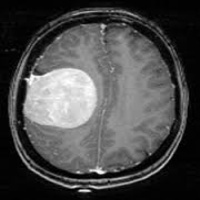

In [139]:
# test cancer brain image

from IPython.display import Image
file_name_c = "prc_Y1.jpg"

## test cancer image:
print("Testing Cancer image:")
infer_braincancer(file_name_c, endpoint_name, object_categories)
Image(file_name_c)

Testing Normal image:
[0.21597999334335327, 0.7840200066566467]
Result: label - Cancer, probability - 0.7840200066566467


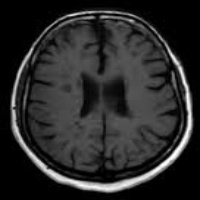

In [140]:
# test normal brain image:

file_name_n = "prc_11 no.jpg"

## test Normal image:
print("Testing Normal image:")
infer_braincancer(file_name_n, endpoint_name, object_categories)
Image(file_name_n)


In [ ]:
## Clean Resources: functions from https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-pipelines/tabular/tensorflow2-california-housing-sagemaker-pipelines-deploy-endpoint/tensorflow2-california-housing-sagemaker-pipelines-deploy-endpoint.ipynb

def delete_model_package_group(sm_client, package_group_name):
    try:
        model_versions = sm_client.list_model_packages(ModelPackageGroupName=package_group_name)

    except Exception as e:
        print("{} \n".format(e))
        return

    for model_version in model_versions["ModelPackageSummaryList"]:
        try:
            sm_client.delete_model_package(ModelPackageName=model_version["ModelPackageArn"])
        except Exception as e:
            print("{} \n".format(e))
        time.sleep(0.5)  # Ensure requests aren't throttled

    try:
        sm_client.delete_model_package_group(ModelPackageGroupName=package_group_name)
        print("{} model package group deleted".format(package_group_name))
    except Exception as e:
        print("{} \n".format(e))
    return


def delete_sagemaker_pipeline(sm_client, pipeline_name):
    try:
        sm_client.delete_pipeline(
            PipelineName=pipeline_name,
        )
        print("{} pipeline deleted".format(pipeline_name))
    except Exception as e:
        print("{} \n".format(e))
        return

In [ ]:
#delete_model_package_group(client, model_package_group_name)
#delete_sagemaker_pipeline(client, pipeline_name)

In [ ]:
## Distributed Training: https://docs.aws.amazon.com/sagemaker/latest/dg/model-parallel.html
# Doesn't seem supported for MXNet Models? https://docs.aws.amazon.com/sagemaker/latest/dg/distributed-model-parallel-support.html


In [ ]:
## multi-model endpoints: https://github.com/aws/amazon-sagemaker-examples/blob/main/advanced_functionality/multi_model_linear_learner_home_value/linear_learner_multi_model_endpoint_inf_pipeline.ipynb

## imporvements:

- IaC
- Version Control   
- Linting and formating   
- Lambda uses a processor instead of the lambda Step   
- Some values like num_training_samples are hardcoded. These should be infered from data and stored somewhere


## to do:

- monitoring

## Notes about the process:
-- the MXNEt model is on page 1430 of the SageMaker Developer Guide 2023  
-- Image classification in Amazon SageMaker can be run in two modes: full training and transfer learning.  
-- Distributed training:  is supported for file mode and pipe mode. When using the RecordIO content type in pipe mode, you must set the S3DataDistributionType of the S3DataSource to FullyReplicated. The algorithm supports a fully replicated model where your data is copied onto each machine.  
-- Inference data types: The algorithm supports image/png, image/jpeg, and application/x-image for inference.  
-- For early stopping hyperparameters (page 1435): early_stopping, early_stopping_min_epochs, early_stopping_patience, early_stopping_tolerance
-- MXNET inference example: https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/imageclassification_caltech/Image-classification-fulltraining.html   

-- Warm pools: create a training job that specifies a KeepAlivePeriodInSeconds
-- Training on Spot instances: EnableManagedSpotTraining to True and specify the MaxWaitTimeInSeconds. MaxWaitTimeInSeconds must be larger than MaxRuntimeInSeconds
-- Inference options: Real time, Severless, Batch, Asynch
-- creating serverless endpoint: https://docs.aws.amazon.com/sagemaker/latest/dg/serverless-endpoints-create.html
-- Shadow testing: page 2298
-- caching available for specific steps: Processing, Tuning, Training, AutoML, Transform, EMR, ClarityCheck and QualityCheck

-- Semantic Segmentation on page 1473 of manual   
-- Semenatic Segmentation example: https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/semantic_segmentation_pascalvoc/semantic_segmentation_pascalvoc.html   